In [1]:
import os
import sys
import requests
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from itertools import product
from datetime import datetime
from datetime import timedelta

import model_settings
from model_settings import ms, vanilla_pricer, barrier_option_pricer
from plotters import plot_surface
from av_fetchers import underlying, link
vanp = vanilla_pricer()
barp = barrier_option_pricer()

search_symbol = 'SPY'
url = f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={search_symbol}&apikey={ms.av_key}"
r = requests.get(url)
data = r.json()
pd.DataFrame(data['bestMatches'])


initializing vanilla pricer
Actual/365 (Fixed) day counter
seed: 123

barrier option pricer initialized


,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,SPY,SPDR S&P 500 ETF Trust,ETF,United States,09:30,16:00,UTC-04,USD,1.0000
1,SPY1.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
2,SPY2.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
3,SPY3.LON,Leverage Shares 3x Long US 500 ETP Securities,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
4,SPY4.FRK,SSgA SPDR S&P 400 US Mid Cap,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
5,SPY4.LON,SPDR® S&P 400 US Mid Cap UCITS ETF,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
6,SPY1.DEX,SPDR® S&P 500 Low Volatility UCITS ETF,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
7,SPY2.DEX,SPDR® Dow Jones Global Real Estate UCITS ETF U...,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
8,SPY4.DEX,SSgA SPDR S&P 400 US Mid Cap,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
9,SPY4.PAR,SSgA SPDR S&P 400 US Mid Cap,ETF,Paris,09:00,17:30,UTC+02,EUR,0.6000


In [2]:
symbol = search_symbol
spots = underlying(symbol,ms.av_key)
spots = pd.Series(spots).astype(float)

# example data collection

let us collect a few recent trading days and inspect the data

In [3]:
dates = pd.Series(spots).index
dates = pd.Series(dates[:5])
print(dates)

0    2024-10-23
1    2024-10-22
2    2024-10-21
3    2024-10-18
4    2024-10-17
dtype: object


In [4]:
spots

2024-10-23    577.9900
2024-10-22    583.3200
2024-10-21    583.6300
2024-10-18    584.5900
2024-10-17    582.3500
                ...   
1999-11-05    137.8750
1999-11-04    136.5312
1999-11-03    135.5000
1999-11-02    134.5937
1999-11-01    135.5625
Length: 6285, dtype: float64

In [5]:
chain = {}
bar = tqdm(total=len(dates))
for date in dates:
    spot = float(spots[date])
    chain_link = link(date,symbol,ms.av_key)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = chain_link
    bar.update(1)
bar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


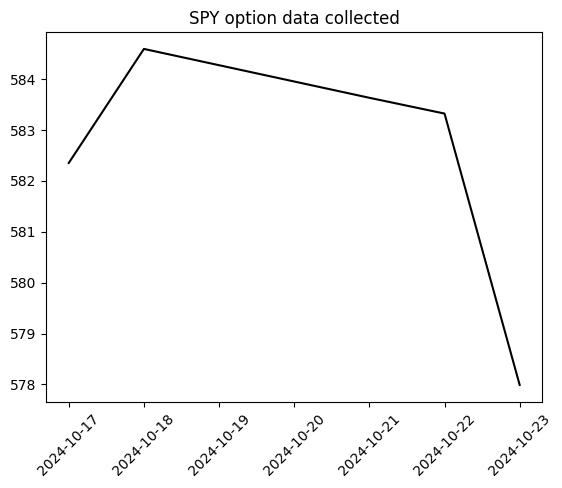

<Figure size 640x480 with 0 Axes>

In [6]:
demo_spots = spots[dates]
demo_spots.index = pd.to_datetime(demo_spots.index, format='%Y-%m-%d')
plt.figure()
plt.plot(demo_spots,color='black')
plt.title(f'{symbol} option data collected')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# example calibraion

now why not select the one trading day and porceed with an example calibration of our Heston (1993) model

In [7]:
date = dates[2]
raw_data = pd.DataFrame(chain[date])
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year,
)
notebook_printdate = str(calculation_datetime.strftime('%A, '))+str(calculation_date)
print(notebook_printdate)

Monday, October 21st, 2024


## extracting calibration contracts

In [8]:
df = raw_data.copy()
df['volume'] = pd.to_numeric(df['volume'])
df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
df['strike'] = pd.to_numeric(df['strike'])
df['volume'] = pd.to_numeric(df['volume'])
df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[df['days_to_maturity']>=7]
df = df[df['volume']>0].copy()
df['spot_price'] = spot
df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
pivoted = df.pivot(index = 'strike',columns='days_to_maturity',values='implied_volatility')


T = np.sort(df['days_to_maturity'].unique())
T = T[T<400]
T = T[np.linspace(0, len(T) - 1, num=5, dtype=int)]

K = np.sort(df['strike'].unique())
K1 = np.sort(pivoted.dropna(how='any',axis=0).index).tolist()
K2 = K[np.linspace(0, len(K) - 1, num=5-len(K1), dtype=int)].tolist()
K = np.sort(np.unique(np.array(K1+K2)))

contracts = pivoted.loc[K,T].unstack().dropna().reset_index().copy()
contracts.columns.values[-1] = 'volatility'

## calibrating a Heston (1993) model

In [9]:
s = spots[date]
r = 0.04
g = 0.0

ql.Settings.instance().evaluationDate = calculation_date
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date,float(r),ql.Actual365Fixed()))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date,float(g),ql.Actual365Fixed()))
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for i,row in contracts.iterrows():
    t = row['days_to_maturity']
    k = row['strike']
    p = ql.Period(int(t),ql.Days)
    volatility = row['volatility']
    helper = ql.HestonModelHelper(
        p, ql.UnitedStates(ql.UnitedStates.NYSE), float(s), k, 
        ql.QuoteHandle(ql.SimpleQuote(volatility)), 
        flat_ts, 
        dividend_ts
        )
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(500, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = {'kappa':kappa,'theta':theta,'rho':rho,'eta':eta,'v0':v0}
heston_parameters = pd.Series(heston_parameters)
print(heston_parameters)


kappa    1.534528
theta    0.055582
rho     -0.999957
eta      0.939482
v0       0.023684
dtype: float64


# repricing calibration contracts

In [10]:
contracts[heston_parameters.index] = np.tile(heston_parameters,(contracts.shape[0],1))
contracts = contracts.rename(columns={'strike':'strike_price'})
contracts['spot_price'] = s
contracts['risk_free_rate'] = r
contracts['dividend_rate'] = g
contracts['w'] = ['call' if d < 0 else 'put' for d in contracts['strike_price']-contracts['spot_price']]
contracts['black_scholes'] = vanp.df_numpy_black_scholes(contracts)
contracts['heston'] = vanp.df_heston_price(contracts)
contracts

,days_to_maturity,strike_price,volatility,kappa,theta,rho,eta,v0,spot_price,risk_free_rate,dividend_rate,w,black_scholes,heston
0,7,540.0,0.24193,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,call,44.104912,44.085086
1,7,600.0,0.07517,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,put,15.919398,15.916728
2,14,540.0,0.21785,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,call,44.753372,44.845984
3,14,600.0,0.09696,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,put,15.884182,15.631357
4,71,540.0,0.20291,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,call,52.350484,53.024561
5,71,544.0,0.19772,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,call,48.798927,49.500448
6,71,600.0,0.12090,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,put,19.259630,17.636636
7,161,540.0,0.19513,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,call,62.757665,63.454165
8,161,544.0,0.19147,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,call,59.423356,60.045684
9,161,600.0,0.12882,1.534528,0.055582,-0.999957,0.939482,0.023684,583.63,0.04,0.0,put,23.089812,21.985245


# train data generation

In [11]:
strike_spread = 0.2
K = np.linspace(
    int(s*(1-strike_spread)),
    int(s*(1+strike_spread)),
    19
).astype(int).tolist()

barrier_step = 10
down_barriers =  np.linspace(
    s*0.5,
    s*0.99,
    7
).astype(int).tolist()

T = [
    30,60,90,
    180,360,540,720
]
print(f"\n{symbol} spot price:\n     {spot}\n\nstrikes:\n     {K}\n\nbarriers:\n     {down_barriers}\n\nmaturities:\n     {T}\n")


SPY spot price:
     582.35

strikes:
     [466, 479, 492, 505, 518, 531, 544, 557, 570, 583, 596, 609, 622, 635, 648, 661, 674, 687, 700]

barriers:
     [291, 339, 387, 434, 482, 530, 577]

maturities:
     [30, 60, 90, 180, 360, 540, 720]



In [12]:
print('generating contracts...')
features = pd.DataFrame(
    product(
        [spot],
        K,
        T,
        down_barriers,
        [0.0], # rebate
        ['put','call'],
        [0.04], # risk-free rate
        [0.0], # dividend rate
        [theta], 
        [kappa], 
        [eta], 
        [rho], 
        [v0],
        ['Out','In']
    ),
    columns = [
        'spot_price',
        'strike_price',
        'days_to_maturity',
        'barrier',
        'rebate',
        'w',
        'risk_free_rate',
        'dividend_rate',
        'theta', 'kappa', 'eta', 'rho', 'v0',
        'outin',
    ]
)
features['moneyness'] = ms.vmoneyness(features['spot_price'],features['strike_price'],features['w'])
features['barrier_type_name'] = 'Down' + features['outin']
print('contracts generated')
print(f'pricing {features.shape[0]} contracts...')
features['vanilla_price'] = vanp.df_heston_price(features)
features['barrier_price'] = barp.df_barrier_price(features)
featuresby_t = features.copy().set_index('days_to_maturity')
print('priced!')

generating contracts...
contracts generated
pricing 3724 contracts...
priced!


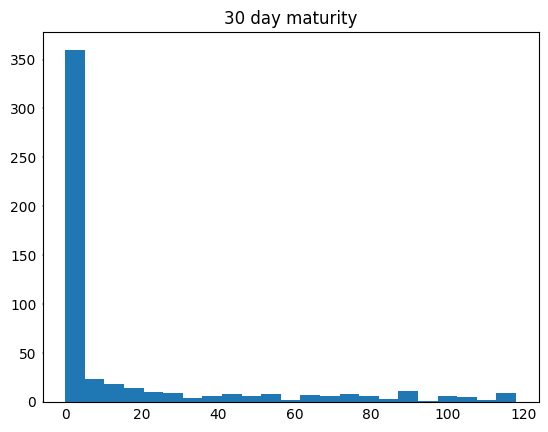

<Figure size 640x480 with 0 Axes>

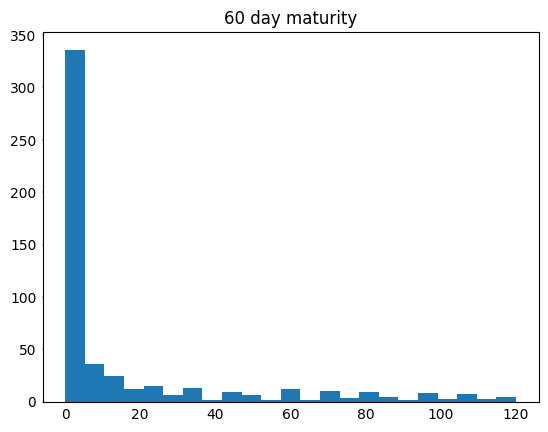

<Figure size 640x480 with 0 Axes>

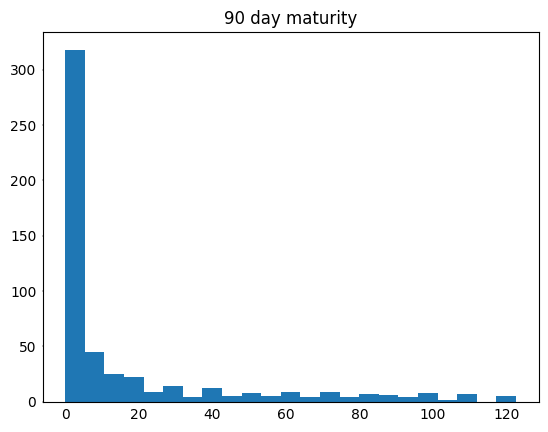

<Figure size 640x480 with 0 Axes>

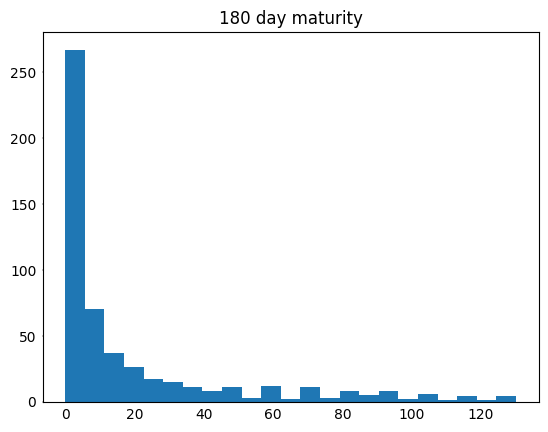

<Figure size 640x480 with 0 Axes>

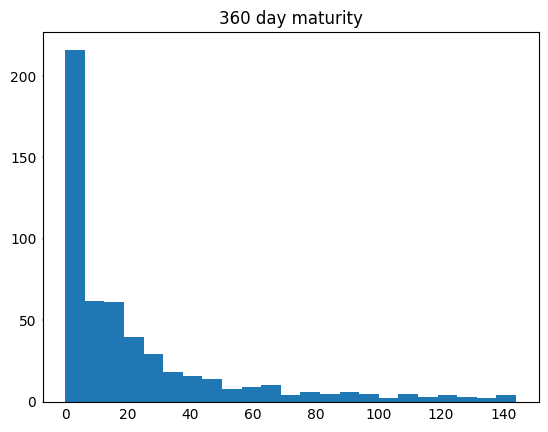

<Figure size 640x480 with 0 Axes>

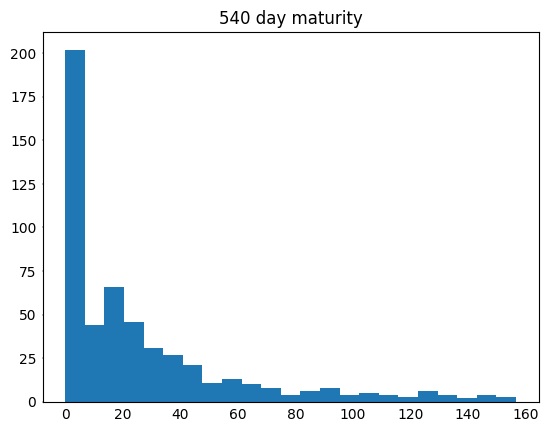

<Figure size 640x480 with 0 Axes>

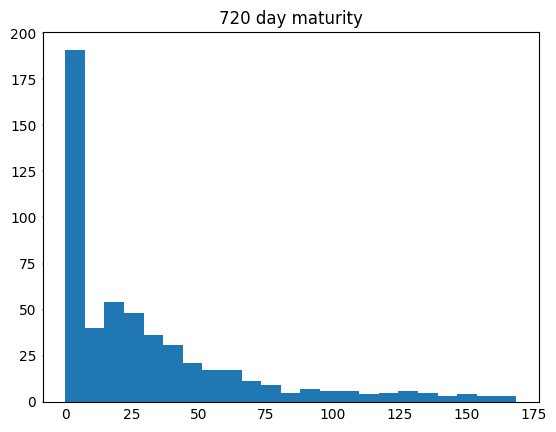

<Figure size 640x480 with 0 Axes>

In [13]:
for t in T:
    plt.figure()
    prices= featuresby_t.loc[t,'barrier_price']
    plt.hist(prices,bins=int(np.sqrt(prices.shape[0])))
    plt.tick_params(axis='both', which='major', length=1, width=1/3)  # Thinner tick marks
    plt.title(f'{t} day maturity')
    plt.show()
    plt.clf()

# model training

In [14]:
import convsklearn
help(convsklearn)

Help on package convsklearn:

NAME
    convsklearn - a proprietary package of convenience wrappers for sklearn

PACKAGE CONTENTS
    convsklearn

DATA
    asian_trainer = <convsklearn.convsklearn.convsklearn object>
    barrier_trainer = <convsklearn.convsklearn.convsklearn object>
    categorical_features = ['averaging_type', 'w']
    numerical_features = ['spot_price', 'strike_price', 'days_to_maturity'...
    target_name = 'observed_price'

FILE
    e:\python\lib\site-packages\convsklearn\__init__.py




In [15]:
from convsklearn import barrier_trainer

In [16]:
help(np.random.normal)

Help on method normal in module numpy.random.mtrand:

normal(loc=0.0, scale=1.0, size=None) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)

    Draw random samples from a normal (Gaussian) distribution.

    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).

    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.

    .. note::
        New code should use the `~numpy.random.Generator.normal`
        method of a `~numpy.random.Generator` instance instead;
        please see the :ref:`random-quick-start`.

    Parameters
    ----------
    loc : float or a

In [17]:
features['observed_price'] = np.maximum(features['barrier_price'] + np.random.normal(scale=(0.15)**2,size=features.shape[0]),0)
    # apply slight peturbation
train_data = features[features['days_to_maturity']!=720]
test_data = features[features['days_to_maturity']==720]
print(f"train data count: {train_data.shape[0]}")
print(f"test data count: {test_data.shape[0]}")
arrs = barrier_trainer.get_train_test_arrays(train_data,test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['train_y']
preprocessor = barrier_trainer.preprocess()
dnn_barriers, runtime, specs = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
in_sample, out_of_sample, errors = barrier_trainer.test_prediction_accuracy(dnn_barriers, test_data, train_data)
outsample = out_of_sample.rename(
    columns = {
        'strike_price':'k',
        'days_to_maturity':'t',
        'barrier_type_name':'type',
        'barrier_price':'price',
        'vanilla_price':'vanilla',
        'spot_price':'spot',
        'outofsample_target':'target',
        'outofsample_prediction':'dnn',
        'outofsample_error':'error',
        'barrier':'b'
        }
)
outsample = outsample[[
    'spot', 'k', 'b','price', 'vanilla', 'type', 'w','t', 
    'target', 'dnn', 'error'
]]
print(f"\n{dnn_barriers}")

train data count: 3192
test data count: 532

training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

in sample:
     RMSE: 5.879938067035562
     MAE: 3.843705156606192

out of sample:
     RMSE: 9.712530953341785
     MAE: 7.6541548385637155

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                   

In [18]:
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_rows",None)
print(f"\n{outsample.describe()}")
outsample_preview = outsample.copy().sort_values(by=['w','type','k','b'],ascending=False).reset_index(drop=True)
print(f"\n{symbol} down barrier options for {notebook_printdate}")
outsample_preview


        spot      k      b  price  vanilla      t  target    dnn  error
count 532.00 532.00 532.00 532.00   532.00 532.00  532.00 532.00 532.00
mean  582.35 583.00 434.29  31.29    62.58 720.00   31.29  34.00   2.71
std     0.00  71.27  95.45  37.46    42.42   0.00   37.46  35.96   9.34
min   582.35 466.00 291.00   0.00    13.61 720.00    0.00  -6.25 -27.97
25%   582.35 518.00 339.00   1.89    28.84 720.00    1.90   8.65  -3.04
50%   582.35 583.00 434.00  19.08    49.28 720.00   19.10  23.67   3.33
75%   582.35 648.00 530.00  43.67    80.55 720.00   43.69  42.23   8.40
max   582.35 700.00 577.00 168.54   168.89 720.00  168.57 177.54  44.15

SPY down barrier options for Monday, October 21st, 2024


,spot,k,b,price,vanilla,type,w,t,target,dnn,error
0,582.35,700,577,0.24,78.15,DownOut,put,720,0.23,12.44,12.21
1,582.35,700,530,2.99,78.15,DownOut,put,720,2.99,18.68,15.69
2,582.35,700,482,8.25,78.15,DownOut,put,720,8.22,25.14,16.93
3,582.35,700,434,15.68,78.15,DownOut,put,720,15.69,26.80,11.11
4,582.35,700,387,24.15,78.15,DownOut,put,720,24.14,28.46,4.32
5,582.35,700,339,33.21,78.15,DownOut,put,720,33.25,34.48,1.24
6,582.35,700,291,42.13,78.15,DownOut,put,720,42.11,47.69,5.58
7,582.35,687,577,0.17,71.67,DownOut,put,720,0.12,10.09,9.97
8,582.35,687,530,2.11,71.67,DownOut,put,720,2.12,16.06,13.95
9,582.35,687,482,6.12,71.67,DownOut,put,720,6.12,22.95,16.83


In [19]:
pd.reset_option("display.max_rows")
pd.reset_option("display.float_format") 